In [1]:
import gzip
import json
import numpy as np
from sklearn.mixture import GaussianMixture
import scipy.io
import numpy.ma as ma
import h5py
import matplotlib.pyplot as plt

In [2]:
f = h5py.File('aic_GMM.h5','r')
aic_all = np.array(f['aic_all'])
f.close()

In [3]:
aic_all.shape

(100, 20, 2)

In [4]:
std = np.std(aic_all,axis=0)

In [5]:
mean = np.mean(aic_all,axis=0)
cil = mean[:,1]-std[:,1]
ciu = mean[:,1]+std[:,1]

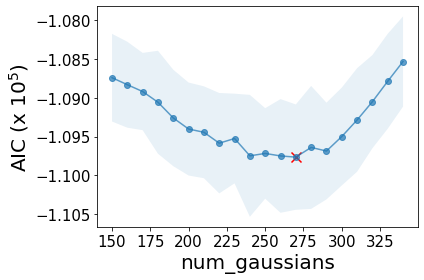

In [6]:
scaling = 10**7
plt.plot(mean[:,0],mean[:,1]/scaling,marker='o',alpha=.7)
plt.fill_between(mean[:,0],cil/scaling,ciu/scaling,alpha=.1)
plt.xlabel('num_gaussians',fontsize=20)
plt.ylabel('AIC (x $10^5$)',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.scatter(mean[np.argmin(mean[:,1]),0],mean[np.argmin(mean[:,1]),1]/scaling,c='r',marker='x',s=100)
# plt.xlim(49,240)
plt.tight_layout()
# plt.ylim(-105,-115)
# plt.savefig('num_gaussians.pdf')
plt.show()


In [7]:
num_gaussians = int(mean[np.argmin(mean[:,1]),0])

In [8]:
#Load angle library from Greg
f = scipy.io.loadmat('/home/antonio/Repositories/ForagingData/shapes.mat')
thetas_w = ma.array(f['theta_ensemble'])
thetas_w[thetas_w==0]=ma.masked
thetas_library_raw = ma.compress_rows(ma.vstack(thetas_w))

#Load library from Onno
mat=h5py.File('/home/antonio/Repositories/ForagingData/PNAS2011-DataStitched.mat','r')
refs=list(mat['#refs#'].keys())[1:]
tseries_w=[ma.masked_invalid(np.array(mat['#refs#'][ref]).T)[:,:5] for ref in refs]
mat.close()
modes_library = ma.compress_rows(ma.vstack(tseries_w))

eigenworms_matrix = np.loadtxt('/home/antonio/Repositories/ForagingData/EigenWorms.csv', delimiter=',').astype(np.float32)

#same number of samples from full theta
# raw_samples = thetas_library_raw[np.random.choice(np.arange(len(thetas_library_raw)),np.sum(indices_curved),replace=False)]
raw_samples = thetas_library_raw[::2]

#find indices with larger curvature
indices_curved = np.abs(modes_library[:,2])>np.percentile(raw_samples.dot(eigenworms_matrix[:,2]),90)
#get same number of samples from raw angles and projected modes
curved_samples = modes_library[indices_curved].dot(eigenworms_matrix[:,:5].T)

thetas_library_combined = np.vstack((curved_samples,raw_samples))

In [9]:
def uniform_samples(a3s,n_bins=100,total_n_samples=20000):
    samples_per_bin = int(total_n_samples/n_bins)
    step = 60/n_bins
    indices=[]
    for x0 in np.linspace(-30,30,n_bins):
        xf = x0+step
        sel = np.logical_and(a3s>=x0,a3s<=xf)
        if np.sum(sel)>0:
            if np.sum(sel)<samples_per_bin:
                indices.append(np.arange(len(a3s))[sel])
            else:
                indices.append(np.random.choice(np.arange(len(a3s))[sel],samples_per_bin,replace=False))
    return np.hstack(indices)

In [10]:
indices = uniform_samples(thetas_library_combined.dot(eigenworms_matrix[:,2]))
training_data = thetas_library_combined[indices]

In [11]:
training_data.shape

(15359, 100)

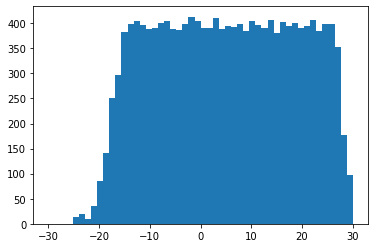

In [12]:
plt.hist(training_data.dot(eigenworms_matrix[:,2]),bins=50,range=[-30,30])
plt.show()

In [13]:
gmm = GaussianMixture(n_components=num_gaussians)#,tol=.1,max_iter=100)
gmm.fit(training_data)

#sort according to curvature
sorting_indices = np.argsort(np.sum(np.abs(np.diff(gmm.means_,axis=1)),axis=1))
means = gmm.means_[sorting_indices]
covariances = gmm.covariances_[sorting_indices]
weights = gmm.weights_[sorting_indices]

In [14]:
n_samples = len(training_data)
n_samples_comp = np.random.multinomial(n_samples, weights)

thetas_samples = np.vstack([
    np.random.multivariate_normal(mean, covariance, int(sample))
    for (mean, covariance, sample) in zip(
        means, covariances, n_samples_comp)])

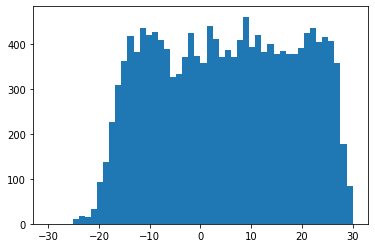

In [15]:
plt.hist(thetas_samples.dot(eigenworms_matrix[:,2]),bins=50,range=[-30,30])
plt.show()

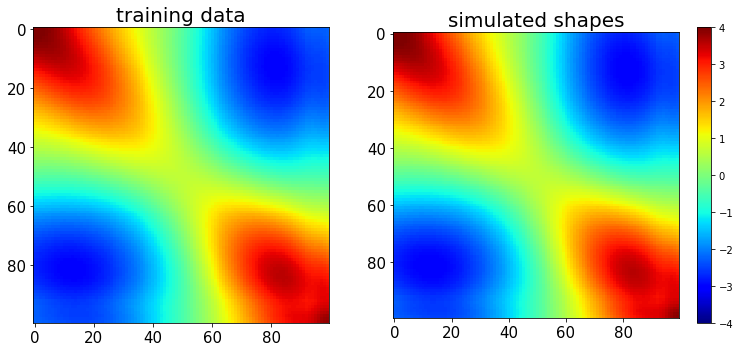

In [18]:
plt.figure(figsize=(11,5))
plt.subplot(1,2,1)
plt.title('training data',fontsize=20)
plt.imshow(np.cov(training_data.T),cmap='jet',vmin=-4,vmax=4)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.subplot(1,2,2)
plt.title('simulated shapes',fontsize=20)
plt.imshow(np.cov(thetas_samples.T),cmap='jet',vmin=-4,vmax=4)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.colorbar()
plt.tight_layout()
# plt.savefig('covariances.pdf')
plt.show()

In [27]:
from matplotlib.colors import LinearSegmentedColormap

cm_data = [[0.2081, 0.1663, 0.5292], [0.2116238095, 0.1897809524, 0.5776761905], 
 [0.212252381, 0.2137714286, 0.6269714286], [0.2081, 0.2386, 0.6770857143], 
 [0.1959047619, 0.2644571429, 0.7279], [0.1707285714, 0.2919380952, 
  0.779247619], [0.1252714286, 0.3242428571, 0.8302714286], 
 [0.0591333333, 0.3598333333, 0.8683333333], [0.0116952381, 0.3875095238, 
  0.8819571429], [0.0059571429, 0.4086142857, 0.8828428571], 
 [0.0165142857, 0.4266, 0.8786333333], [0.032852381, 0.4430428571, 
  0.8719571429], [0.0498142857, 0.4585714286, 0.8640571429], 
 [0.0629333333, 0.4736904762, 0.8554380952], [0.0722666667, 0.4886666667, 
  0.8467], [0.0779428571, 0.5039857143, 0.8383714286], 
 [0.079347619, 0.5200238095, 0.8311809524], [0.0749428571, 0.5375428571, 
  0.8262714286], [0.0640571429, 0.5569857143, 0.8239571429], 
 [0.0487714286, 0.5772238095, 0.8228285714], [0.0343428571, 0.5965809524, 
  0.819852381], [0.0265, 0.6137, 0.8135], [0.0238904762, 0.6286619048, 
  0.8037619048], [0.0230904762, 0.6417857143, 0.7912666667], 
 [0.0227714286, 0.6534857143, 0.7767571429], [0.0266619048, 0.6641952381, 
  0.7607190476], [0.0383714286, 0.6742714286, 0.743552381], 
 [0.0589714286, 0.6837571429, 0.7253857143], 
 [0.0843, 0.6928333333, 0.7061666667], [0.1132952381, 0.7015, 0.6858571429], 
 [0.1452714286, 0.7097571429, 0.6646285714], [0.1801333333, 0.7176571429, 
  0.6424333333], [0.2178285714, 0.7250428571, 0.6192619048], 
 [0.2586428571, 0.7317142857, 0.5954285714], [0.3021714286, 0.7376047619, 
  0.5711857143], [0.3481666667, 0.7424333333, 0.5472666667], 
 [0.3952571429, 0.7459, 0.5244428571], [0.4420095238, 0.7480809524, 
  0.5033142857], [0.4871238095, 0.7490619048, 0.4839761905], 
 [0.5300285714, 0.7491142857, 0.4661142857], [0.5708571429, 0.7485190476, 
  0.4493904762], [0.609852381, 0.7473142857, 0.4336857143], 
 [0.6473, 0.7456, 0.4188], [0.6834190476, 0.7434761905, 0.4044333333], 
 [0.7184095238, 0.7411333333, 0.3904761905], 
 [0.7524857143, 0.7384, 0.3768142857], [0.7858428571, 0.7355666667, 
  0.3632714286], [0.8185047619, 0.7327333333, 0.3497904762], 
 [0.8506571429, 0.7299, 0.3360285714], [0.8824333333, 0.7274333333, 0.3217], 
 [0.9139333333, 0.7257857143, 0.3062761905], [0.9449571429, 0.7261142857, 
  0.2886428571], [0.9738952381, 0.7313952381, 0.266647619], 
 [0.9937714286, 0.7454571429, 0.240347619], [0.9990428571, 0.7653142857, 
  0.2164142857], [0.9955333333, 0.7860571429, 0.196652381], 
 [0.988, 0.8066, 0.1793666667], [0.9788571429, 0.8271428571, 0.1633142857], 
 [0.9697, 0.8481380952, 0.147452381], [0.9625857143, 0.8705142857, 0.1309], 
 [0.9588714286, 0.8949, 0.1132428571], [0.9598238095, 0.9218333333, 
  0.0948380952], [0.9661, 0.9514428571, 0.0755333333], 
 [0.9763, 0.9831, 0.0538]]

parula_map = LinearSegmentedColormap.from_list('parula', cm_data)
# For use of "viscm view"

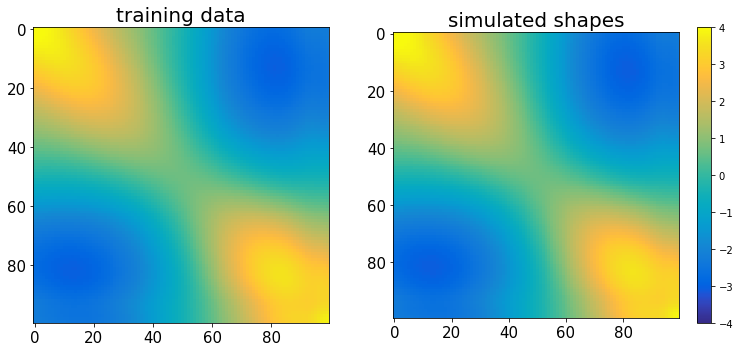

In [28]:
plt.figure(figsize=(11,5))
plt.subplot(1,2,1)
plt.title('training data',fontsize=20)
plt.imshow(np.cov(training_data.T),cmap=parula_map,vmin=-4,vmax=4)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.subplot(1,2,2)
plt.title('simulated shapes',fontsize=20)
plt.imshow(np.cov(thetas_samples.T),cmap=parula_map,vmin=-4,vmax=4)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.colorbar()
plt.tight_layout()
plt.savefig('covariances_parula.pdf')
plt.show()

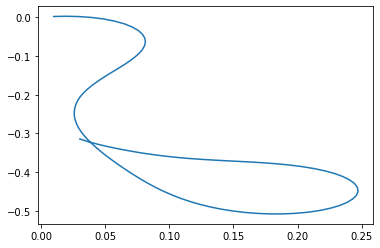

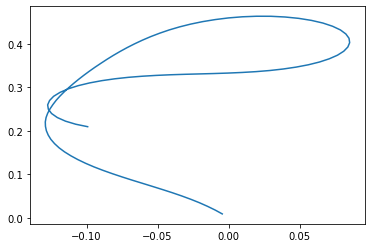

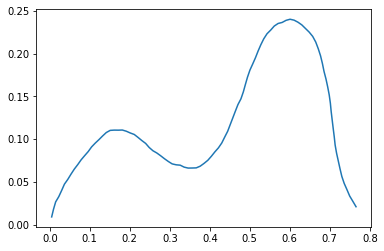

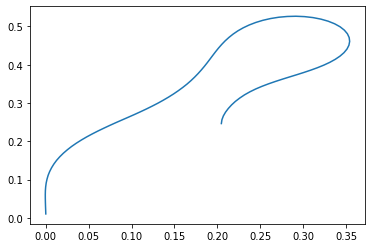

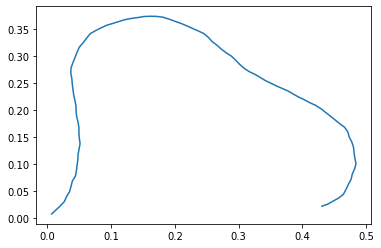

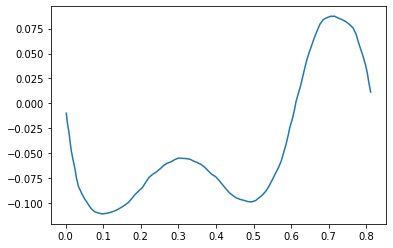

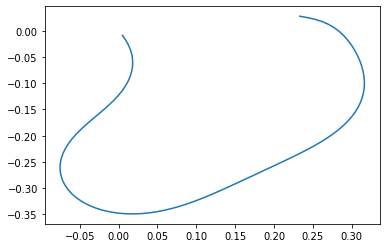

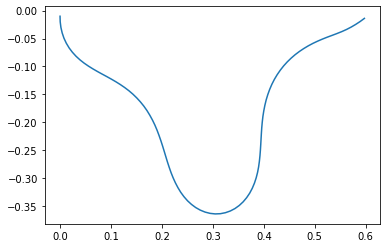

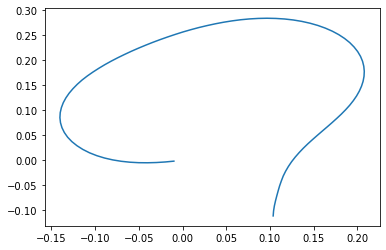

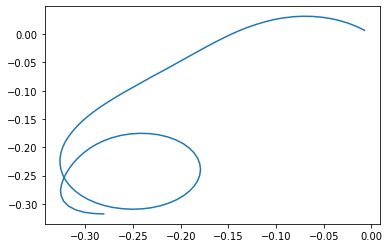

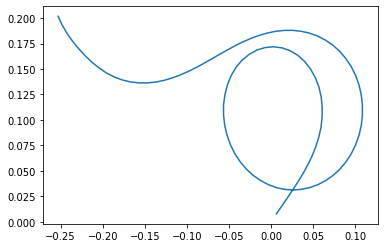

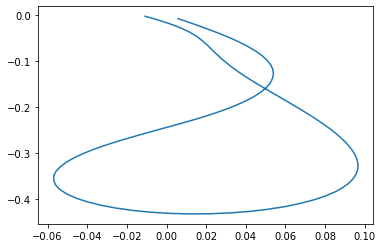

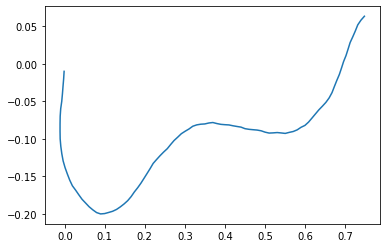

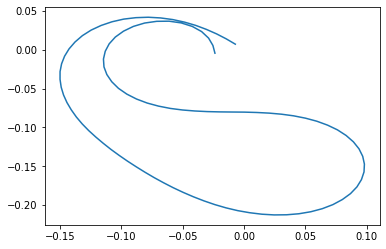

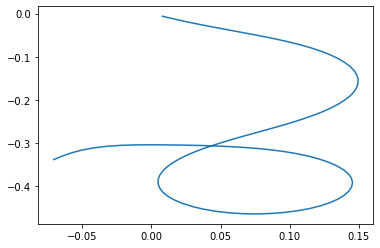

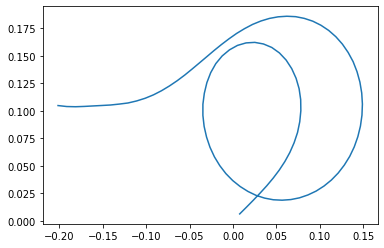

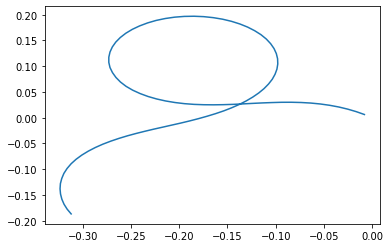

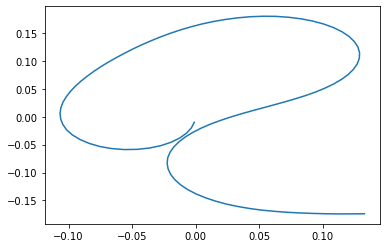

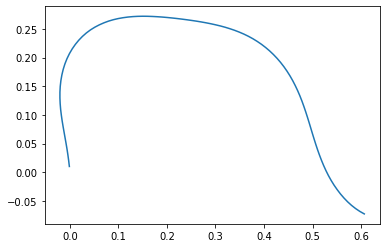

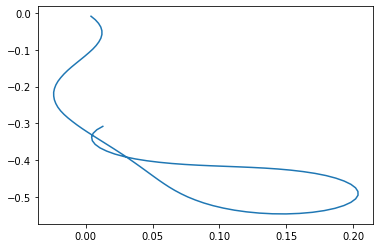

In [27]:
for theta in thetas_samples[np.random.randint(0,len(thetas_samples),20)]:
    x,y = calculate_backbone_points(theta,1)
    plt.plot(x,y)
    plt.show()